# Estimating-the-correlation-length 

* A central parameter for the DIVAnd analysis is the correlation length
* It determines whether two points separated by a given distance are correlated or not
* DIVAnd includes several tools to estimate the correlation length
* We will start with a 2D case and consider the 3D case

In [3]:
using Base.Test
import divand
using PyPlot

Download the file `Salinity.bigfile` (if it is not already present). It will be placed in the same directory as this notebook. This file based on the World Ocean Database.

In [4]:
fname = "Salinity.bigfile"

if !isfile(fname)
    download("https://b2drop.eudat.eu/s/Bv9Fj0YGC0zp2vn/download",fname)
else
    info("Data file already downloaded")
end

INFO: Data file already downloaded


Load the data

In [5]:
value,lon,lat,depth,time,ids = divand.loadbigfile(fname);

`mincount` is the minimum number of observations per distance bin and the call to `srand` ensures a reproducible sequence of random numbers.


In [10]:
mincount = 100
srand(12345); # this can be any number

## 2D case

* First lets consider only the data on a 2D surface (longitude and latitude)
* We use the function `divand.fit_isotropic`


In [11]:
?divand.fit_isotropic

```
var0,len,distx,covar,fitcovar = fit_isotropic(x,v,distbin,mincount;
                           alpha = divand.alpha_default(length(x)),
                           minlen = 0.,
                           maxlen = 10.,
                           tolrel = 1e-4,
                           maxpoints = 10000,
                           nmean = 100,
                           distfun = (xi,xj) -> sqrt(sum(abs2,xi-xj))),
                           progress = (iter,var,len,fitness) -> nothing
                       )
```

Determines the optimal correlation length `len` and variance (for a separation distance approaching zero) `var0` of a cloud of data points with value `v` and coordiantes `x` (tuple of vectors with the coordinates).

The function can find the solution corresponding to  a local minimum which is not necessarily the global minimum.

See also `empiriccovar` for future information about the output parameters.

Optional input parameters:

  * `alpha`: if one correlation length is forced to zero during the anaylsis the values of alpha sould be set using the effective dimension. For example, if a 2D-analysis is simulated by forcing the vertical correlation length to zero, then alpha should be set to `[1,2,1]`, otherwise alpha will be `[1,3,3,1]` (for for any proper 3D analysis).
  * `len`: initial value for the correlation length
  * `minlen`, `maxlen`: minimum and maximum value for the correlation length
  * `tolrel`: relative tolerance for the optimizer
  * `maxpoints`: maximum number of data points considered
  * `nmean`: the number of time an empirical covariance is estimated.  The average covariance is used for the fitting.
  * `distfun`: function to compute the distance between point `xi` (vector) and  `xj`. Per default `distun` is the Eucedian distance `(xi,xj) -> sqrt(sum(abs2,xi-xj)))`.
  * `progress`: call-back function to show the progress of the optimization with the input parameters `iter`, `var`, `len` and `fitness` (all scalars).

The length-scale parameters and the variance have the corresponding units from the `x` and `v`. It is therefore often necessary to provide reasonable values for these default parameters.

The algorithm used to estimate the correlation-length and variance is based on randomly choosen points. Therefore the result can be different if the function is invoked repeately. If `nmean` is increased, then these statistical fluctuations should decrease (for a not too large value of `mincount`, i.e. about 100 for most cases).

If the lower bound `minlen` is too small, then you might get the following error:

```
AmosException with id 4: input argument magnitude too large, complete loss of accuracy by argument reduction.
```

In these case, increase `minlen`.


INFO: Making empirical covariance
INFO: Fitting empirical covariance


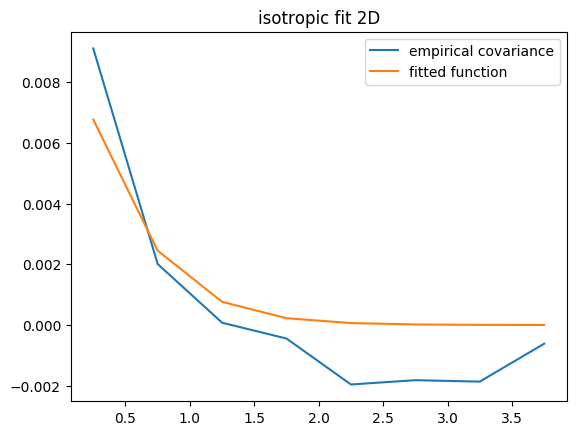

PyObject Text(0.5,1,u'isotropic fit 2D')

In [14]:
# surface values for the month January
sel = (depth .> 10) .& Dates.month.(time) .== 1;
x = (lon[sel],lat[sel]);
v = value[sel] - mean(value[sel]);
distbin = 0:0.5:4

var0,len,distx,covar,fitcovar = divand.fit_isotropic(x,v,distbin,mincount)


figure()
plot(distx,covar, label = "empirical covariance")
plot(distx,fitcovar, label = "fitted function")
legend()
title("isotropic fit 2D")

The data from the file `Salinity.bigfile` is already interpolated on z levels which makes it not ideal to explore the vertical correlation.
The file `WOD-Salinity-Provencal.nc` is the salinity data from the World Ocean Database for the Provençal Basin (Mediterranean Sea).

The resulting correlation length can fluctuate a bit because the correlation is based on a collection of random pairs. Increasing `nmean` can be the estimation of the correlation more robust.

In [16]:
varname = "Salinity"
filename = "WOD-Salinity-Provencal.nc"

if !isfile(filename)    
    download("https://b2drop.eudat.eu/s/UsF3RyU3xB1UM2o/download",filename)
end

value,lon,lat,depth,time,ids = divand.loadobs(Float64,filename,"Salinity")

divand.checkobs((lon,lat,depth,time),value,ids)


sel = (Dates.month.(time) .== 1)
x = (lon[sel],lat[sel],depth[sel]);
v = value[sel]
z = [0.,10,100,200,300,400,500,700,1000,1500]


srand(1234);
@time lenz,infoz = divand.fitvertlen(x,v,z, nmean = 500, distbin = collect([0.:50:400; 500:100:600]))


srand(1234);
@time lenxy,infoxy = divand.fithorzlen(x,v,z, nmean = 500, distbin = collect(0.:0.1:6))



              minimum and maximum of obs. dimension 1: (3.0418334007263184, 11.8100004196167)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (-0.0, 2762.0)
              minimum and maximum of obs. dimension 4: (1892-09-25T00:00:00, 2017-10-02T06:14:02.761)
                          minimum and maximum of data: (0.25, 40.0)


INFO: Making empirical covariance
INFO: Fitting empirical covariance


Data points at z=0.0: 225570, correlation length: 105.54455445544555
Data points at z=10.0: 225570, correlation length: 117.82178217821782


INFO: Making empirical covariance
INFO: Fitting empirical covariance
INFO: Making empirical covariance
INFO: Fitting empirical covariance
INFO: Making empirical covariance
INFO: Fitting empirical covariance
INFO: Making empirical covariance
INFO: Fitting empirical covariance


Data points at z=100.0: 225570, correlation length: 122.97029702970298
Data points at z=200.0: 225570, correlation length: 77.82178217821782
Data points at z=300.0: 225570, correlation length: 391.48514851485146
Data points at z=400.0: 225570, correlation length: 81.68316831683168


INFO: Making empirical covariance
INFO: Fitting empirical covariance
INFO: Making empirical covariance
INFO: Fitting empirical covariance
INFO: Making empirical covariance
INFO: Fitting empirical covariance
INFO: Making empirical covariance
INFO: Fitting empirical covariance


Data points at z=500.0: 225570, correlation length: 115.54455445544555
Data points at z=700.0: 225570, correlation length: 195.14851485148515
Data points at z=1000.0: 225570, correlation length: 1000.0
Data points at z=1500.0: 225570, correlation length: 278.71287128712873
123.934183 seconds (1.24 G allocations: 100.987 GiB, 26.48% gc time)


INFO: Making empirical covariance
INFO: Fitting empirical covariance


Data points at z=0.0: 86141, correlation length: 0.13712371237123713
Data points at z=10.0: 87901, correlation length: 0.13306330633063307


INFO: Making empirical covariance
INFO: Fitting empirical covariance
INFO: Making empirical covariance
INFO: Fitting empirical covariance
INFO: Making empirical covariance
INFO: Fitting empirical covariance
INFO: Making empirical covariance
INFO: Fitting empirical covariance
INFO: Making empirical covariance
INFO: Fitting empirical covariance


Data points at z=100.0: 101834, correlation length: 0.13538353835383538
Data points at z=200.0: 114742, correlation length: 0.12552255225522552
Data points at z=300.0: 125816, correlation length: 0.11798179817981798
Data points at z=400.0: 102006, correlation length: 0.1


INFO: Making empirical covariance
INFO: Fitting empirical covariance
INFO: Making empirical covariance
INFO: Fitting empirical covariance
INFO: Making empirical covariance
INFO: Fitting empirical covariance
INFO: Making empirical covariance
INFO: Fitting empirical covariance


Data points at z=500.0: 83943, correlation length: 0.1
Data points at z=700.0: 64682, correlation length: 0.14147414741474149
Data points at z=1000.0: 47423, correlation length: 0.1
Data points at z=1500.0: 30885, correlation length: 0.1
259.529478 seconds (511.20 M allocations: 418.832 GiB, 26.95% gc time)


INFO: Making empirical covariance
INFO: Fitting empirical covariance


([0.133283, 0.133253, 0.131593, 0.124972, 0.115901, 0.106338, 0.105989, 0.135452, 0.101544, 0.100016], Dict{Symbol,Any}(Pair{Symbol,Any}(:fitcovar, [0.0102217 0.00985673 … 0.00264528 0.00512845; 0.00647306 0.00612749 … 0.00132894 0.00257643; … ; 2.81416e-20 7.53325e-21 … 1.2092e-27 2.34429e-27; 1.36851e-20 3.58278e-21 … 4.48577e-28 8.69664e-28]),Pair{Symbol,Any}(:covar, [0.0114935 0.0111442 … 0.00319393 0.00619213; 0.00834035 0.00804067 … 0.000299024 -0.000351238; … ; -0.00399266 -0.00463854 … -0.00648836 -0.00368318; -0.00749096 5.1458e-5 … -0.0083332 -0.0043064]),Pair{Symbol,Any}(:stdcovar, [0.00298006 0.00269624 … 0.00269881 0.00280859; 0.00227058 0.00229667 … 0.000190241 0.000252162; … ; 0.0179786 0.0201399 … 0.0061593 0.00377685; 0.0349846 0.108149 … 0.00806418 0.00476596]),Pair{Symbol,Any}(:len, [0.137124, 0.133063, 0.135384, 0.125523, 0.117982, 0.1, 0.1, 0.141474, 0.1, 0.1]),Pair{Symbol,Any}(:distx, [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95  …  5.05, 5.15, 5.25